In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

dataset1.csv is converted to utf-8. dataset.csv is the maine data acquired from Stack Overflow.

In [43]:
df = pd.read_csv('dataset1.csv', encoding='ISO-8859-1')
# Save it with UTF-8 encoding(Conversion)
df.to_csv('dataset.csv', index=False, encoding='utf-8')
df = pd.read_csv('dataset.csv')

In [51]:
# Remocing HTML tags from  'accepted_answer_body' 
df['accepted_answer_body'] = df['accepted_answer_body'].apply(
    lambda x: BeautifulSoup(x, "html.parser").get_text() if isinstance(x, str) else x
)
df['body'] = df['body'].apply(
    lambda x: BeautifulSoup(x, "html.parser").get_text() if isinstance(x, str) else x
)
df.to_csv('dataset_html_cleaned.csv', index=False, encoding='utf-8')

In [ ]:
# df = pd.read_csv('dataset_html_cleaned.csv')
# df.head()

In [ ]:
# df.head()
#  df_cleaned.to_csv("final_cleaned_withouthtml.csv",index=False)

In [55]:

# nltk.download('punkt')
# nltk.download('stopwords')
# Define stopwords and preserve domain-relevant terms
stop_words = set(stopwords.words('english'))
preserve_words = {"not", "nlp", "bert", "spacy", "nltk", "token", "model", "huggingface"}
stop_words = stop_words - preserve_words

# Heavily preprocessed version for WordClouds and advanced NLP
def heavy_clean_text(text):
    if pd.isnull(text):
        # Step 1: Handle missing/null values
        return ""

    # Step 2: Convert to lowercase
    text = text.lower()

    # Step 3: Remove <img> tags
    text = re.sub(r'<img[^>]*>', '', text)

    # Step 4: Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Step 5: Remove non-alphanumeric characters
    text = re.sub(r'[^a-z0-9\s]', '', text)

    # Step 6: Tokenize the text
    tokens = word_tokenize(text)

    # Step 7: Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]

    # Step 8: Remove numeric-only and long tokens
    tokens = [t for t in tokens if len(t) <= 20 and not t.isnumeric()]

    # Step 9: Join back to a string
    return ' '.join(tokens).strip()

# Lightly cleaned version for manual categorization
def light_clean_text(text):
    if pd.isnull(text):
        # Hanlding missing values
        return ""

    # Step 2: Convert to lowercase
    text = text.lower()

    # Step 3: Remove <img> tags
    text = re.sub(r'<img[^>]*>', '', text)

    # Step 4: Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Step 5: Keep punctuation for human readability
    return text.strip()

# loading dataset
df = pd.read_csv("dataset_html_cleaned.csv")

# Light version for manual categorization
light_df = df.copy()
light_df = light_df.drop_duplicates(subset=["title"])
light_df["title"] = light_df["title"].apply(light_clean_text)
light_df["body"] = light_df["body"].apply(light_clean_text)
light_df["accepted_answer_body"] = light_df["accepted_answer_body"].apply(light_clean_text)
light_df.to_csv("original_version.csv", index=False)

# Heavy version for NLP tasks
heavy_df = df.copy()
heavy_df = heavy_df.drop_duplicates(subset=["title"])
heavy_df["title"] = heavy_df["title"].apply(heavy_clean_text)
heavy_df["body"] = heavy_df["body"].apply(heavy_clean_text)
heavy_df["accepted_answer_body"] = heavy_df["accepted_answer_body"].apply(heavy_clean_text)
heavy_df.to_csv("preprocessed.csv", index=False)

print("Two files generated:")
print("- original_version.csv (for manual reading and categorization)")
print("- preprocessed.csv (for word cloud and NLP models)")


Two files generated:
- original_version.csv (for manual reading and categorization)
- preprocessed.csv (for word cloud and NLP models)


In [1]:
# df=pd.read_csv("original_version.csv")
# df.head()

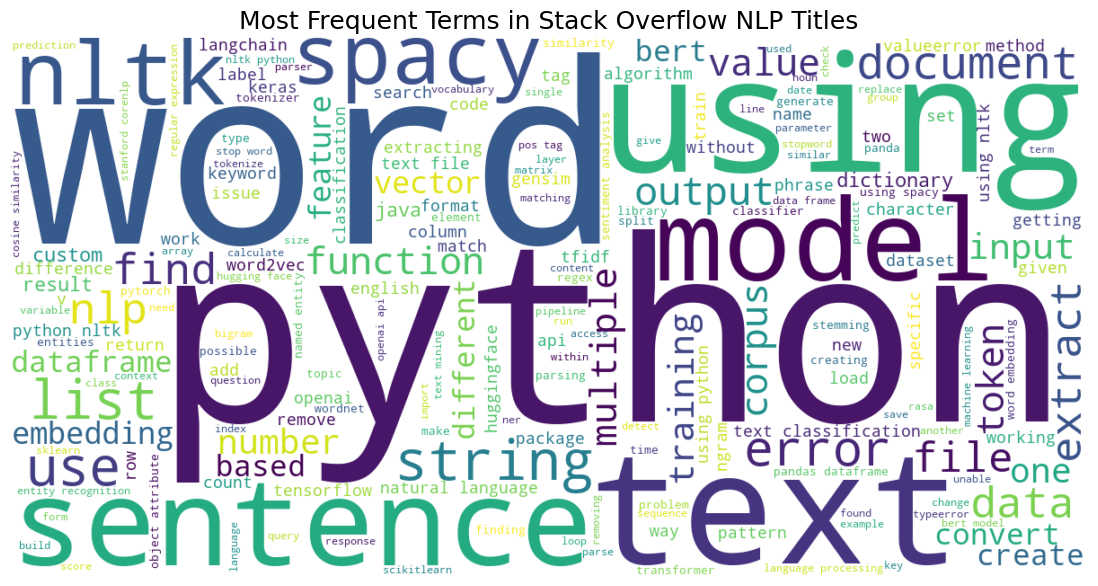

In [56]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the preprocessed dataset
df = pd.read_csv('preprocessed.csv')


# Combine all cleaned titles into one string
text = ' '.join(df['title'].dropna().astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in Stack Overflow NLP Titles", fontsize=18)
plt.show()


In [36]:
df.shape

(14587, 8)

In [ ]:
# # light_df = pd.read_csv("original_version.csv")
# light_df.head()

In [87]:
import pandas as pd
import numpy as np

# Load the lightly cleaned dataset
light_df = pd.read_csv("original_version.csv")
light_df = light_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into 3 equal parts
splits = np.array_split(light_df, 3)

# Assign and save each part
splits[0].to_csv("for_categorization_christen.csv", index=False)
splits[1].to_csv("for_categorization_utsav.csv", index=False)
splits[2].to_csv("for_categorization_shridarshan.csv", index=False)

print("Simplified split completed:")
print("- for_categorization_christen.csv")
print("- for_categorization_utsav.csv")
print("- for_categorization_shridarshan.csv")


D:\Anaconda\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Simplified split completed:
- for_categorization_christen.csv
- for_categorization_utsav.csv
- for_categorization_shridarshan.csv


In [7]:
# df=pd.read_csv("for_categorization_utsav.csv")
# df.head()

## Acquiring Metadata

In [106]:
import pandas as pd
import requests
import time
from datetime import datetime

#  API Config 
API_KEY = "rl_MdVXEpV7UgL1XMwe5e5BwoqEa"
API_BASE = "https://api.stackexchange.com/2.3/questions/"
BATCH_SIZE = 100
SLEEP_BETWEEN_BATCHES = 2.5

#  Retry-safe request 
def fetch_with_retries(url, retries=3, delay=3):
    for attempt in range(retries):
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                return response
            print(f"Attempt {attempt+1} failed with status {response.status_code}")
        except requests.exceptions.RequestException as e:
            print(f"Network error: {e}. Retrying...")
        time.sleep(delay)
    return None

#  Convert Unix timestamp to readable datetime 
def to_datetime(unix_ts):
    if pd.isnull(unix_ts):
        return None
    return datetime.utcfromtimestamp(unix_ts).strftime('%d-%m-%Y %H:%M')

#  Metadata enrichment function 
def enrich_with_metadata(input_file, output_file):
    print(f"\nProcessing: {input_file}")

    df = pd.read_csv(input_file)
    question_ids = df["question_id"].dropna().astype(int).unique().tolist()
    fetched_data = []

    for i in range(0, len(question_ids), BATCH_SIZE):
        batch_ids = question_ids[i:i + BATCH_SIZE]
        ids_str = ";".join(map(str, batch_ids))
        url = f"{API_BASE}{ids_str}?order=desc&sort=activity&site=stackoverflow&filter=!-*jbN-o8P3E5&key={API_KEY}"
        response = fetch_with_retries(url)
        if not response:
            print(f"Skipping batch {i//BATCH_SIZE + 1}")
            continue

        for item in response.json().get("items", []):
            fetched_data.append({
                "question_id": item["question_id"],
                "creation_date": to_datetime(item.get("creation_date")),
                "view_count": item.get("view_count"),
                "score": item.get("score"),
                "answer_count": item.get("answer_count"),
                "is_answered": item.get("is_answered"),
                "last_activity_date": to_datetime(item.get("last_activity_date")),
                "last_edit_date": to_datetime(item.get("last_edit_date")),
            })

        print(f"Fetched batch {i//BATCH_SIZE + 1} ({len(fetched_data)} posts so far)")
        time.sleep(SLEEP_BETWEEN_BATCHES)

    # Merge metadata and drop rows with missing values
    meta_df = pd.DataFrame(fetched_data)
    merged_df = df.merge(meta_df, on="question_id", how="left")
    merged_df = merged_df.dropna()  # Drop any rows with missing metadata
    merged_df.to_csv(output_file, index=False)

    print(f"Data saved to: {output_file}")


In [108]:
enrich_with_metadata("for_categorization_christen.csv", "split_part1_christen_with_metadata.csv")
enrich_with_metadata("for_categorization_utsav.csv", "split_part2_shridarshan_with_metadata.csv")
enrich_with_metadata("for_categorization_shridarshan.csv", "split_part3_utsav_with_metadata.csv")



🔍 Processing: for_categorization_christen.csv


C:\Users\utsav\AppData\Local\Temp\ipykernel_17268\3455129464.py:29: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(unix_ts).strftime('%d-%m-%Y %H:%M')


✅ Fetched batch 1 (30 posts so far)
✅ Fetched batch 2 (60 posts so far)
✅ Fetched batch 3 (90 posts so far)
✅ Fetched batch 4 (120 posts so far)
✅ Fetched batch 5 (150 posts so far)
✅ Fetched batch 6 (180 posts so far)
✅ Fetched batch 7 (210 posts so far)
✅ Fetched batch 8 (240 posts so far)
✅ Fetched batch 9 (270 posts so far)
✅ Fetched batch 10 (300 posts so far)
✅ Fetched batch 11 (330 posts so far)
✅ Fetched batch 12 (360 posts so far)
✅ Fetched batch 13 (390 posts so far)
✅ Fetched batch 14 (420 posts so far)
✅ Fetched batch 15 (450 posts so far)
✅ Fetched batch 16 (480 posts so far)
✅ Fetched batch 17 (510 posts so far)
✅ Fetched batch 18 (540 posts so far)
✅ Fetched batch 19 (570 posts so far)
✅ Fetched batch 20 (600 posts so far)
✅ Fetched batch 21 (630 posts so far)
✅ Fetched batch 22 (660 posts so far)
✅ Fetched batch 23 (690 posts so far)
✅ Fetched batch 24 (720 posts so far)
✅ Fetched batch 25 (750 posts so far)
✅ Fetched batch 26 (780 posts so far)
✅ Fetched batch 27 (810 

C:\Users\utsav\AppData\Local\Temp\ipykernel_17268\3455129464.py:29: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(unix_ts).strftime('%d-%m-%Y %H:%M')


✅ Fetched batch 1 (30 posts so far)
✅ Fetched batch 2 (60 posts so far)
✅ Fetched batch 3 (90 posts so far)
✅ Fetched batch 4 (120 posts so far)
✅ Fetched batch 5 (150 posts so far)
✅ Fetched batch 6 (180 posts so far)
✅ Fetched batch 7 (210 posts so far)
✅ Fetched batch 8 (240 posts so far)
✅ Fetched batch 9 (270 posts so far)
✅ Fetched batch 10 (300 posts so far)
✅ Fetched batch 11 (330 posts so far)
✅ Fetched batch 12 (360 posts so far)
✅ Fetched batch 13 (390 posts so far)
✅ Fetched batch 14 (420 posts so far)
✅ Fetched batch 15 (450 posts so far)
✅ Fetched batch 16 (480 posts so far)
✅ Fetched batch 17 (510 posts so far)
✅ Fetched batch 18 (540 posts so far)
✅ Fetched batch 19 (570 posts so far)
✅ Fetched batch 20 (600 posts so far)
✅ Fetched batch 21 (630 posts so far)
✅ Fetched batch 22 (660 posts so far)
✅ Fetched batch 23 (690 posts so far)
✅ Fetched batch 24 (720 posts so far)
✅ Fetched batch 25 (750 posts so far)
✅ Fetched batch 26 (780 posts so far)
✅ Fetched batch 27 (810 

C:\Users\utsav\AppData\Local\Temp\ipykernel_17268\3455129464.py:29: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(unix_ts).strftime('%d-%m-%Y %H:%M')


✅ Fetched batch 1 (30 posts so far)
✅ Fetched batch 2 (60 posts so far)
✅ Fetched batch 3 (90 posts so far)
✅ Fetched batch 4 (120 posts so far)
✅ Fetched batch 5 (150 posts so far)
✅ Fetched batch 6 (180 posts so far)
✅ Fetched batch 7 (210 posts so far)
✅ Fetched batch 8 (240 posts so far)
✅ Fetched batch 9 (270 posts so far)
✅ Fetched batch 10 (300 posts so far)
✅ Fetched batch 11 (330 posts so far)
✅ Fetched batch 12 (360 posts so far)
✅ Fetched batch 13 (390 posts so far)
✅ Fetched batch 14 (420 posts so far)
✅ Fetched batch 15 (450 posts so far)
✅ Fetched batch 16 (480 posts so far)
✅ Fetched batch 17 (510 posts so far)
✅ Fetched batch 18 (540 posts so far)
✅ Fetched batch 19 (570 posts so far)
✅ Fetched batch 20 (600 posts so far)
✅ Fetched batch 21 (630 posts so far)
✅ Fetched batch 22 (660 posts so far)
✅ Fetched batch 23 (690 posts so far)
✅ Fetched batch 24 (720 posts so far)
✅ Fetched batch 25 (750 posts so far)
✅ Fetched batch 26 (780 posts so far)
✅ Fetched batch 27 (810 

In [10]:
# dd=pd.read_csv("split_part3_utsav_with_metadata.csv")
# dd.head()

After acquiring meta data, We observed that there are many NaN values. Hence we drop those rows.

In [ ]:
# === NA-dropping utility ===
def drop_na_and_save(input_file, output_file):
    df = pd.read_csv(input_file)
    df = df.dropna(how='any')
    df.to_csv(output_file, index=False)
    print(f"Cleaned (NA removed) file saved to: {output_file}")

In [119]:
drop_na_and_save("split_part1_christen_with_metadata.csv", "split_part1_christen_clean.csv")
drop_na_and_save("split_part2_shridarshan_with_metadata.csv", "split_part2_shridarshan_clean.csv")
drop_na_and_save("split_part3_utsav_with_metadata.csv", "split_part3_utsav_clean.csv")

Cleaned (NA removed) file saved to: split_part1_christen_clean.csv
Cleaned (NA removed) file saved to: split_part2_shridarshan_clean.csv
Cleaned (NA removed) file saved to: split_part3_utsav_clean.csv


In [7]:
import pandas as pd

# Load the files
df1 = pd.read_csv("split_part1_christen_with_metadata.csv")
df2 = pd.read_csv("split_part2_shridarshan_with_metadata.csv")
df3 = pd.read_csv("split_part3_utsav_with_metadata.csv")

# Merge them
merged_df = pd.concat([df1, df2, df3], ignore_index=True)

# Save to new Excel
merged_df.to_csv("merged_output.csv", index=False)
